In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

In [2]:
def ma_model(epsilon_prev, const, theta, sigma2):
    """ X_t = const + epsilon_t + theta * epsilon_{t-1} """

    epsilon_t = np.random.normal(loc=0, scale=np.sqrt(sigma2))
    next_logr = const + epsilon_t + theta * epsilon_prev

    return next_logr

# Round 1

In [3]:
price_0 = pd.read_csv('../data/raw/round_1/prices_round_1_day_-2.csv', delimiter=';')
price_1 = pd.read_csv('../data/raw/round_1/prices_round_1_day_-1.csv', delimiter=';')
price_2 = pd.read_csv('../data/raw/round_1/prices_round_1_day_0.csv', delimiter=';')

In [4]:
price_0 = price_0[price_0['product'] == 'KELP']
price_1 = price_1[price_1['product'] == 'KELP']
price_2 = price_2[price_2['product'] == 'KELP']

In [5]:
trades_0 = pd.read_csv('../data/raw/round_1/trades_round_1_day_-2.csv', delimiter=';')
trades_1 = pd.read_csv('../data/raw/round_1/trades_round_1_day_-1.csv', delimiter=';')
trades_2 = pd.read_csv('../data/raw/round_1/trades_round_1_day_0.csv', delimiter=';')

In [6]:
trades_0 = trades_0[trades_0['symbol'] == 'KELP']
trades_1 = trades_1[trades_1['symbol'] == 'KELP']
trades_2 = trades_2[trades_2['symbol'] == 'KELP']

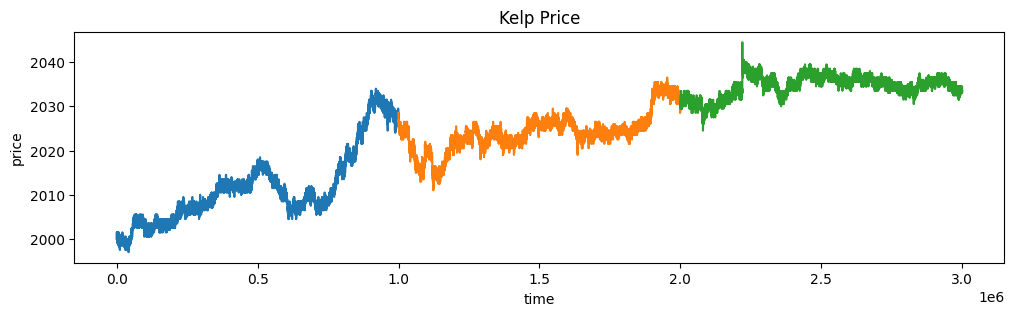

In [7]:
plt.figure(figsize=(12, 3))
plt.plot(price_0['timestamp'], price_0['mid_price'])
plt.plot(price_1['timestamp'] + 1000000, price_1['mid_price'])
plt.plot(price_2['timestamp'] + 2000000, price_2['mid_price'])
plt.title('Kelp Price')
plt.xlabel('time')
plt.ylabel('price')
plt.show()

In [8]:
prices = pd.concat([price_0, price_1, price_2], axis=0).reset_index(drop=True)
trades = pd.concat([trades_0, trades_1, trades_2], axis=0).reset_index(drop=True)

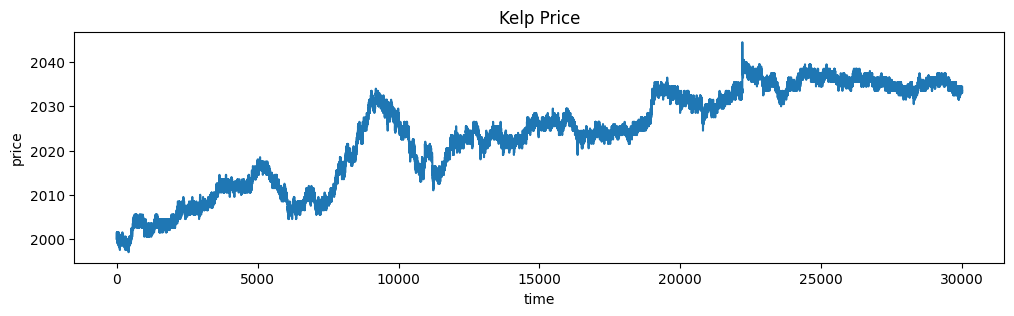

In [9]:
plt.figure(figsize=(12, 3))
plt.plot(prices['mid_price'])
plt.title('Kelp Price')
plt.xlabel('time')
plt.ylabel('price')
plt.show()

In [10]:
bid_prices = prices[['bid_price_1', 'bid_price_2', 'bid_price_3']].to_numpy()
max_inds = prices[['bid_volume_1', 'bid_volume_2', 'bid_volume_3']].idxmax(axis=1).apply(lambda x: int(x[-1]) - 1).to_numpy()
pop_bid_prices = bid_prices[np.arange(len(bid_prices)), max_inds]

ask_prices = prices[['ask_price_1', 'ask_price_2', 'ask_price_3']].to_numpy()
max_inds = prices[['ask_volume_1', 'ask_volume_2', 'ask_volume_3']].idxmax(axis=1).apply(lambda x: int(x[-1]) - 1).to_numpy()
pop_ask_prices = ask_prices[np.arange(len(ask_prices)), max_inds]

prices = prices.assign(pop_bid_price=pop_bid_prices)
prices = prices.assign(pop_ask_price=pop_ask_prices)
prices = prices.assign(pop_mid_price=(pop_bid_prices + pop_ask_prices) / 2)

In [11]:
filtered_mid_prices = []
for i in range(prices.shape[0]):
    price = prices.iloc[i]
    bid_prices = price[['bid_price_1', 'bid_price_2', 'bid_price_3']].to_numpy()
    bid_volumes = price[['bid_volume_1', 'bid_volume_2', 'bid_volume_3']].to_numpy()
    bids = dict(zip(bid_prices, bid_volumes))
    ask_prices = price[['ask_price_1', 'ask_price_2', 'ask_price_3']].to_numpy()
    ask_volumes = price[['ask_volume_1', 'ask_volume_2', 'ask_volume_3']].to_numpy()
    asks = dict(zip(ask_prices, ask_volumes))
    
    filtered_asks = [price for price in asks if abs(asks[price]) >= 15]
    filtered_bids = [price for price in bids if abs(bids[price]) >= 15]
    best_filtered_ask = min(filtered_asks) if len(filtered_asks) > 0 else None
    best_filtered_bid = max(filtered_bids) if len(filtered_bids) > 0 else None

    if best_filtered_ask and best_filtered_bid:
        filtered_mid_price = (best_filtered_ask + best_filtered_bid) / 2
    else:
        filtered_mid_price = price['mid_price']
    filtered_mid_prices.append(filtered_mid_price)
prices = prices.assign(filtered_mid_price=filtered_mid_prices)

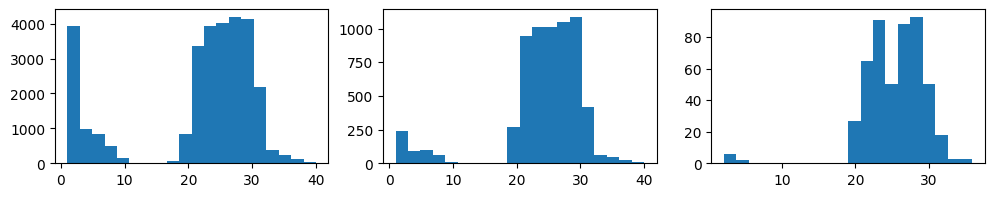

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(12, 2))
ax[0].hist(prices['bid_volume_1'], bins=20)
ax[1].hist(prices['bid_volume_2'], bins=20)
ax[2].hist(prices['bid_volume_3'], bins=20)
plt.show()

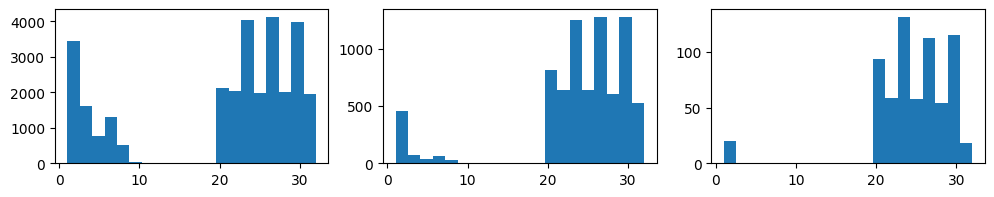

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(12, 2))
ax[0].hist(prices['ask_volume_1'], bins=20)
ax[1].hist(prices['ask_volume_2'], bins=20)
ax[2].hist(prices['ask_volume_3'], bins=20)
plt.show()

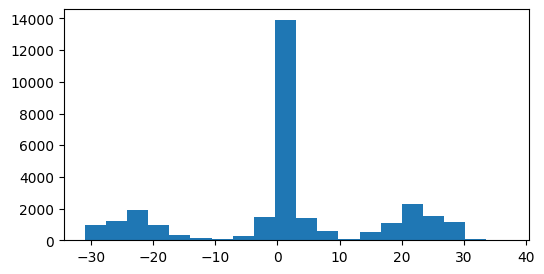

In [14]:
plt.figure(figsize=(6, 3))
plt.hist(prices['bid_volume_1'] - prices['ask_volume_1'], bins=20)
plt.show()

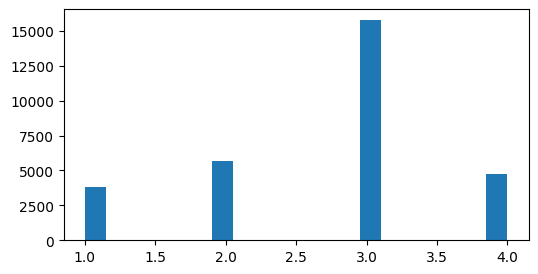

In [15]:
plt.figure(figsize=(6, 3))
plt.hist(prices['ask_price_1'] - prices['bid_price_1'], bins=20)
plt.show()

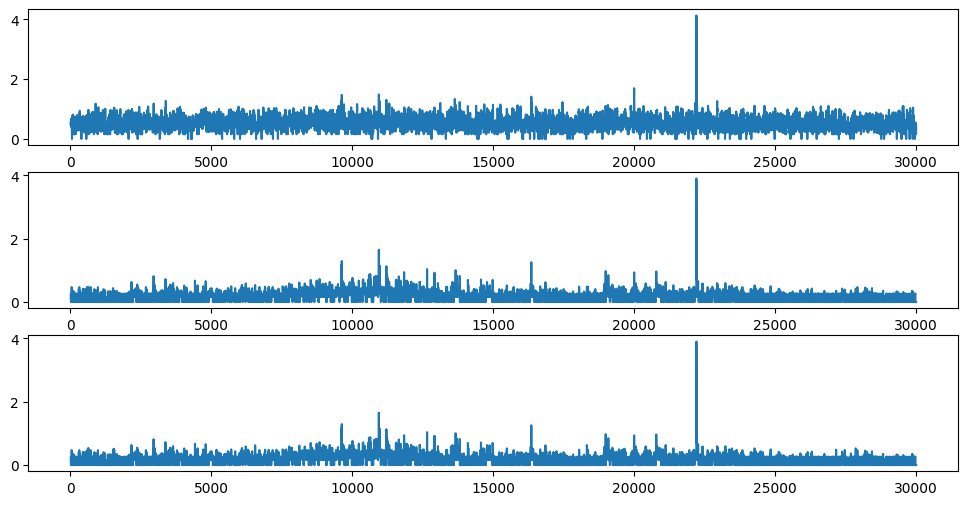

In [16]:
fig, ax = plt.subplots(3, 1, figsize=(12, 6))
ax[0].plot(prices['mid_price'].rolling(10).std())
ax[1].plot(prices['pop_mid_price'].rolling(10).std())
ax[2].plot(prices['filtered_mid_price'].rolling(10).std())
plt.show()

In [17]:
price = prices.iloc[1000:1100]

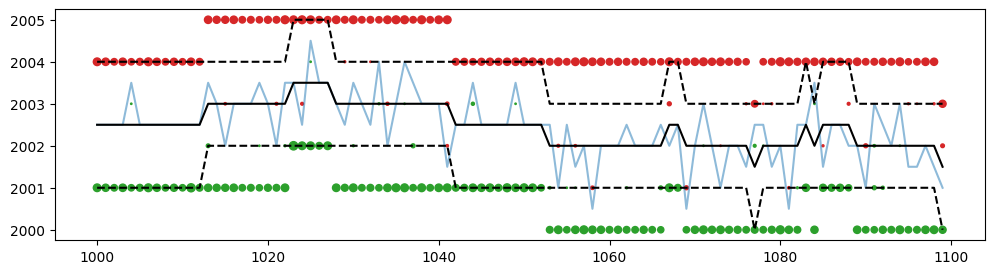

In [18]:
plt.figure(figsize=(12, 3))
plt.scatter(price['timestamp']//100, price['bid_price_1'], s=price['bid_volume_1'], c='tab:green')
plt.scatter(price['timestamp']//100, price['bid_price_2'], s=price['bid_volume_2'], c='tab:green')
plt.scatter(price['timestamp']//100, price['bid_price_3'], s=price['bid_volume_3'], c='tab:green')
plt.scatter(price['timestamp']//100, price['ask_price_1'], s=price['ask_volume_1'], c='tab:red')
plt.scatter(price['timestamp']//100, price['ask_price_2'], s=price['ask_volume_2'], c='tab:red')
plt.scatter(price['timestamp']//100, price['ask_price_3'], s=price['ask_volume_3'], c='tab:red')
plt.plot(price['timestamp']//100, price['mid_price'], c='tab:blue', alpha=0.5)
plt.plot(price['timestamp']//100, price['pop_mid_price'], c='k')
plt.plot(price['timestamp']//100, np.floor(price['pop_mid_price']) - 1, c='k', linestyle='dashed')
plt.plot(price['timestamp']//100, np.ceil(price['pop_mid_price']) + 1, c='k', linestyle='dashed')
plt.show()

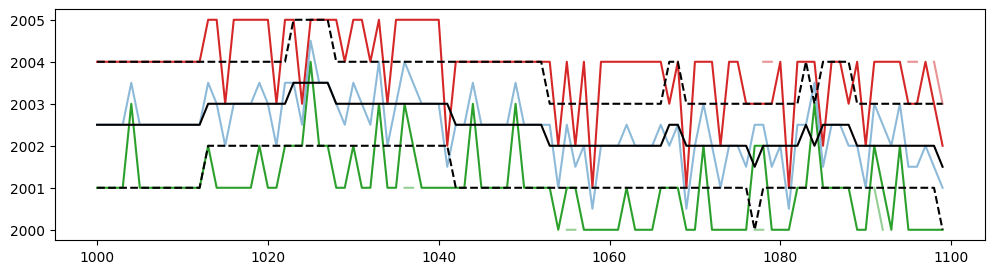

In [19]:
plt.figure(figsize=(12, 3))
plt.plot(price['timestamp']//100, price['bid_price_1'], c='tab:green')
plt.plot(price['timestamp']//100, price['bid_price_2'], c='tab:green', alpha=0.5)
plt.plot(price['timestamp']//100, price['bid_price_3'], c='tab:green', alpha=0.5)
plt.plot(price['timestamp']//100, price['ask_price_1'], c='tab:red')
plt.plot(price['timestamp']//100, price['ask_price_2'], c='tab:red', alpha=0.5)
plt.plot(price['timestamp']//100, price['ask_price_3'], c='tab:red', alpha=0.5)
plt.plot(price['timestamp']//100, price['mid_price'], c='tab:blue', alpha=0.5)
plt.plot(price['timestamp']//100, price['pop_mid_price'], c='k')
plt.plot(price['timestamp']//100, np.floor(price['pop_mid_price']) - 1, c='k', linestyle='dashed')
plt.plot(price['timestamp']//100, np.ceil(price['pop_mid_price']) + 1, c='k', linestyle='dashed')
plt.show()

## Price prediction - popular mid price

In [20]:
# train = prices['mid_price'].iloc[:prices.shape[0] // 3].to_numpy()
# valid = prices['mid_price'].iloc[prices.shape[0] // 3:prices.shape[0] // 3 * 2].to_numpy()
# test = prices['mid_price'].iloc[prices.shape[0] // 3 * 2:].to_numpy()

# train_logr = np.log(train[1:] / train[:-1])
# valid_logr = np.log(valid[1:] / valid[:-1])
# test_logr = np.log(test[1:] / test[:-1])

# plt.figure(figsize=(12, 3))
# plt.scatter(np.arange(len(train_logr)), train_logr, marker='.')
# plt.title('Kelp Log Returns - mid price')
# plt.xlabel('time')
# plt.ylabel('Log Return')
# plt.show()

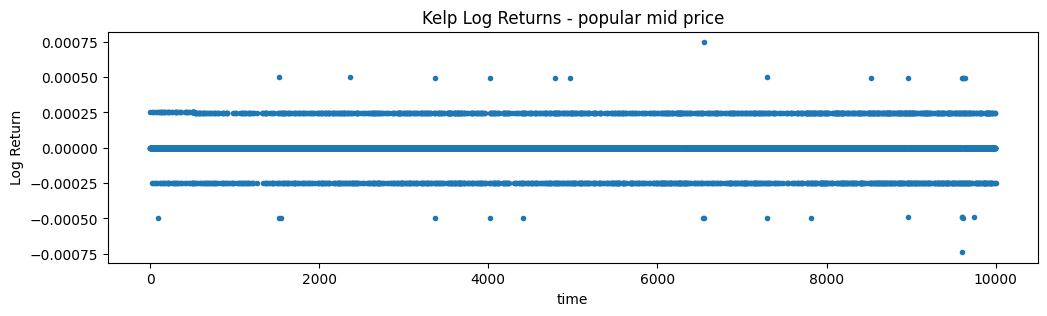

In [21]:
train = prices['pop_mid_price'].iloc[:prices.shape[0] // 3].to_numpy()
valid = prices['pop_mid_price'].iloc[prices.shape[0] // 3:prices.shape[0] // 3 * 2].to_numpy()
test = prices['pop_mid_price'].iloc[prices.shape[0] // 3 * 2:].to_numpy()

train_logr = np.log(train[1:] / train[:-1])
valid_logr = np.log(valid[1:] / valid[:-1])
test_logr = np.log(test[1:] / test[:-1])

plt.figure(figsize=(12, 3))
plt.scatter(np.arange(len(train_logr)), train_logr, marker='.')
plt.title('Kelp Log Returns - popular mid price')
plt.xlabel('time')
plt.ylabel('Log Return')
plt.show()

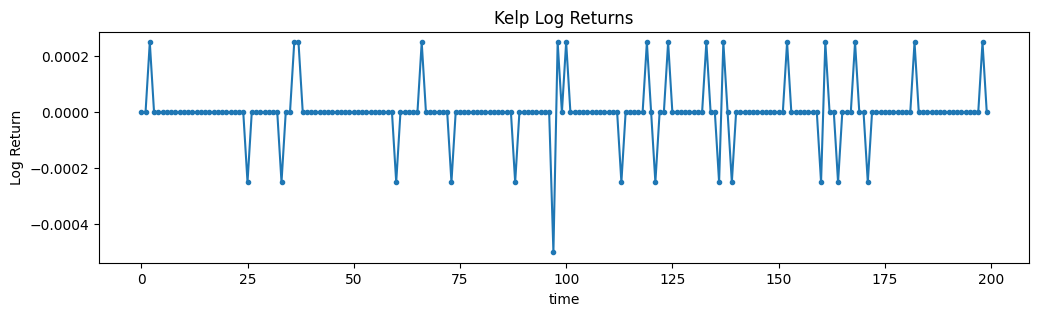

In [22]:
plt.figure(figsize=(12, 3))
plt.plot(np.arange(len(train_logr[:200])), train_logr[:200], marker='.')
plt.title('Kelp Log Returns')
plt.xlabel('time')
plt.ylabel('Log Return')
plt.show()

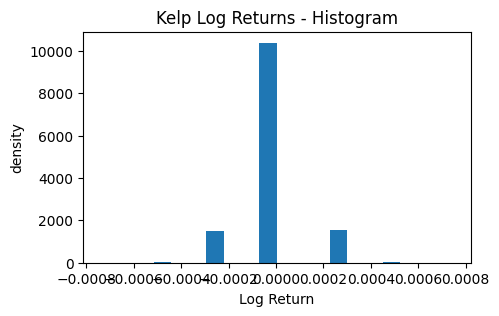

In [23]:
plt.figure(figsize=(5, 3))
plt.hist(train_logr, bins=20, density=True)
plt.title('Kelp Log Returns - Histogram')
plt.xlabel('Log Return')
plt.ylabel('density')
plt.show()

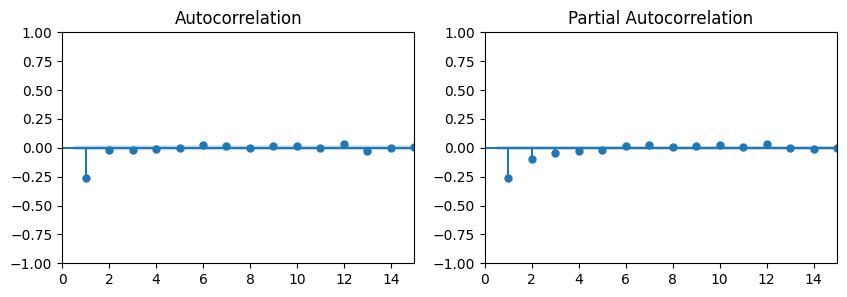

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
plot_acf(train_logr, ax=ax[0], zero=False)
plot_pacf(train_logr, ax=ax[1], zero=False)
ax[0].set_xlim([0, 15])
ax[1].set_xlim([0, 15])
plt.show()

In [25]:
# Perform Ljung-Box test for lags up to 10
result = acorr_ljungbox(train_logr, lags=[10], return_df=True)
print(result)

# Interpretation
if result['lb_pvalue'].values[0] > 0.05:
    print("Fail to reject null hypothesis: data may be white noise.")
else:
    print("Reject null hypothesis: data is not white noise.")

       lb_stat      lb_pvalue
10  701.837954  2.531660e-144
Reject null hypothesis: data is not white noise.


### Naive

In [26]:
rmse = np.mean(valid_logr ** 2) ** 0.5
print(f'Log-returns RMSE: {rmse}')

y = valid[1:]
y_pred = valid[:-1]
err = y - y_pred
rmse = np.mean(err ** 2) ** 0.5
print(f'Price RMSE: {rmse}')

Log-returns RMSE: 0.00013231476377939335
Price RMSE: 0.267735257702122


In [27]:
rmse = np.mean(test_logr ** 2) ** 0.5
print(f'Log-returns RMSE - test set: {rmse}')

y = test[1:]
y_pred = test[:-1]
err = y - y_pred
rmse = np.mean(err ** 2) ** 0.5
print(f'Price RMSE - test set: {rmse}')

Log-returns RMSE - test set: 0.00012116630086041733
Price RMSE - test set: 0.24663958139015488


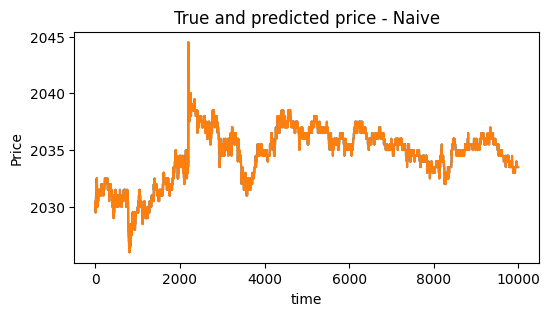

In [28]:
plt.figure(figsize=(6, 3))
plt.plot(y)
plt.plot(y_pred)
plt.title('True and predicted price - Naive')
plt.xlabel('time')
plt.ylabel('Price')
plt.show()

### AR(1)

In [29]:
coeffs = np.polyfit(train_logr[:-1], train_logr[1:], deg=1)
a, b = coeffs

In [30]:
print(a, b)

-0.2620219858049914 1.7302653799072463e-06


In [31]:
preds = valid_logr[:-1] * -0.262

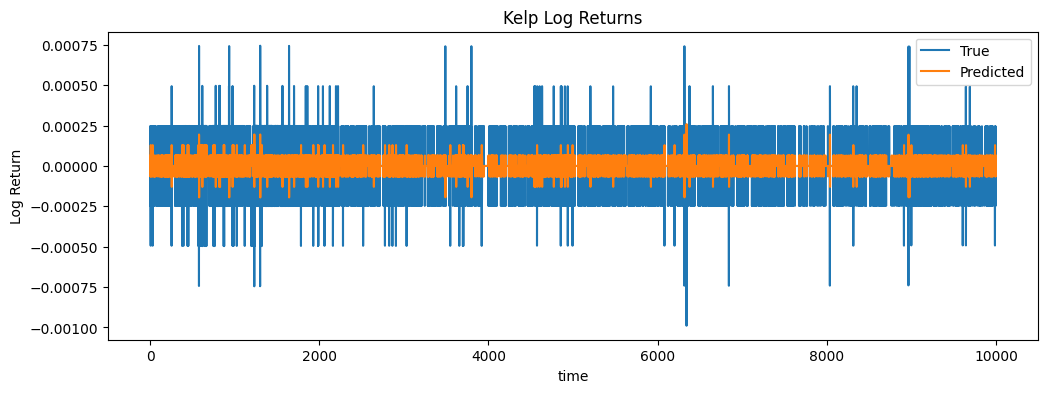

In [32]:
plt.figure(figsize=(12, 4))
plt.plot(valid_logr[1:], label='True')
plt.plot(preds, label='Predicted')
plt.title('Kelp Log Returns')
plt.xlabel('time')
plt.ylabel('Log Return')
plt.legend()
plt.show()

In [33]:
pred_price = valid[1:-1] * np.exp(preds)

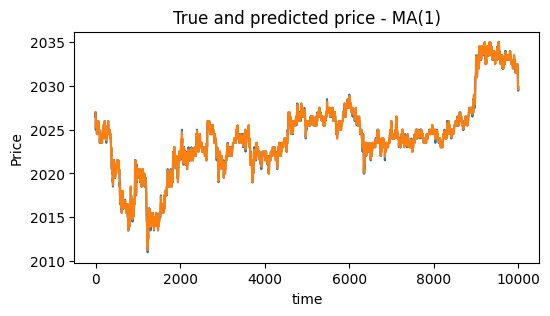

In [34]:
plt.figure(figsize=(6, 3))
plt.plot(valid[2:])
plt.plot(pred_price)
plt.title('True and predicted price - MA(1)')
plt.xlabel('time')
plt.ylabel('Price')
plt.show()

In [35]:
err = valid_logr[1:] - preds
rmse = np.mean(err ** 2) ** 0.5
print(f'Log-returns RMSE: {rmse}')

err = valid[2:] - pred_price
rmse = np.mean(err ** 2) ** 0.5
print(f'Price RMSE: {rmse}')

Log-returns RMSE: 0.00012814350483993526
Price RMSE: 0.25928564082602307


-> Selected model: AR(1)

In [36]:
preds = test_logr[:-1] * -0.262

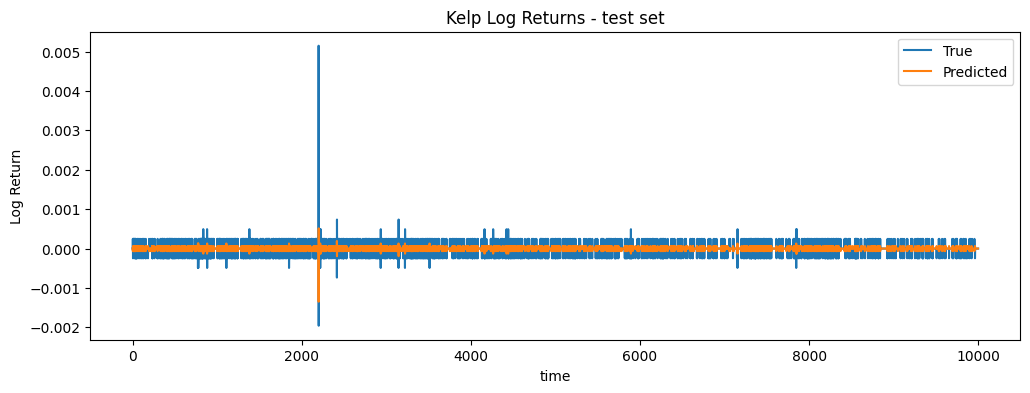

In [37]:
plt.figure(figsize=(12, 4))
plt.plot(test_logr, label='True')
plt.plot(preds, label='Predicted')
plt.title('Kelp Log Returns - test set')
plt.xlabel('time')
plt.ylabel('Log Return')
plt.legend()
plt.show()

In [38]:
pred_price = test[1:-1] * np.exp(preds)

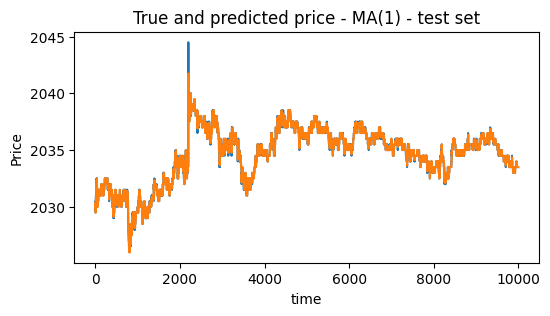

In [39]:
plt.figure(figsize=(6, 3))
plt.plot(test[2:])
plt.plot(pred_price)
plt.title('True and predicted price - MA(1) - test set')
plt.xlabel('time')
plt.ylabel('Price')
plt.show()

In [40]:
err = test_logr[1:] - preds
rmse = np.mean(err ** 2) ** 0.5
print(f'Log-returns RMSE - test set: {rmse}')

err = test[2:] - pred_price
rmse = np.mean(err ** 2) ** 0.5
print(f'Price RMSE - test set: {rmse}')

Log-returns RMSE - test set: 0.00011605321420694254
Price RMSE - test set: 0.23622145924467564


## Price prediction - Filtered orders

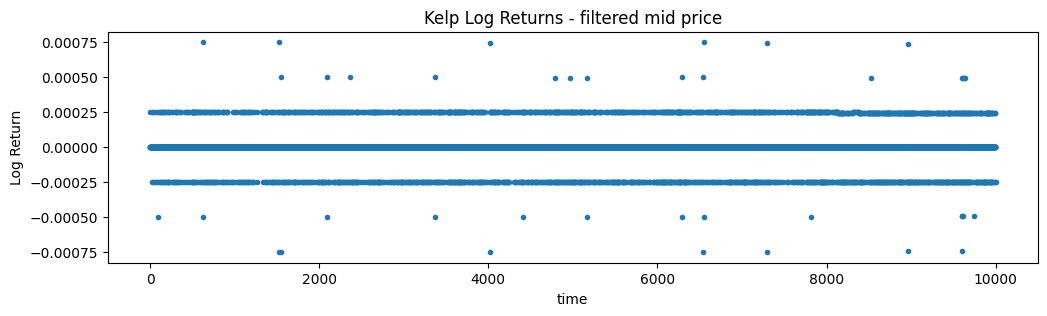

In [41]:
train = prices['filtered_mid_price'].iloc[:prices.shape[0] // 3].to_numpy()
valid = prices['filtered_mid_price'].iloc[prices.shape[0] // 3:prices.shape[0] // 3 * 2].to_numpy()
test = prices['filtered_mid_price'].iloc[prices.shape[0] // 3 * 2:].to_numpy()

train_logr = np.log(train[1:] / train[:-1])
valid_logr = np.log(valid[1:] / valid[:-1])
test_logr = np.log(test[1:] / test[:-1])

plt.figure(figsize=(12, 3))
plt.scatter(np.arange(len(train_logr)), train_logr, marker='.')
plt.title('Kelp Log Returns - filtered mid price')
plt.xlabel('time')
plt.ylabel('Log Return')
plt.show()

### Naive

In [42]:
rmse = np.mean(valid_logr ** 2) ** 0.5
print(f'Log-returns RMSE: {rmse}')

y = valid[1:]
y_pred = valid[:-1]
err = y - y_pred
rmse = np.mean(err ** 2) ** 0.5
print(f'Price RMSE: {rmse}')

Log-returns RMSE: 0.00013391917358860606
Price RMSE: 0.27098402763691337


In [43]:
rmse = np.mean(test_logr ** 2) ** 0.5
print(f'Log-returns RMSE - test set: {rmse}')

y = test[1:]
y_pred = test[:-1]
err = y - y_pred
rmse = np.mean(err ** 2) ** 0.5
print(f'Price RMSE - test set: {rmse}')

Log-returns RMSE - test set: 0.00012201101958103702
Price RMSE - test set: 0.24835693692106062


### AR(1)

In [44]:
coeffs = np.polyfit(train_logr[:-1], train_logr[1:], deg=1)
a, b = coeffs
print(a, b)

-0.27112647090009795 1.7429257912785499e-06


In [45]:
preds = valid_logr[:-1] * -0.2711

In [46]:
pred_price = valid[1:-1] * np.exp(preds)

In [47]:
err = valid_logr[1:] - preds
rmse = np.mean(err ** 2) ** 0.5
print(f'Log-returns RMSE: {rmse}')

err = valid[2:] - pred_price
rmse = np.mean(err ** 2) ** 0.5
print(f'Price RMSE: {rmse}')

Log-returns RMSE: 0.0001295333188404377
Price RMSE: 0.262099454034004


In [48]:
preds = test_logr[:-1] * -0.2711

In [49]:
pred_price = test[1:-1] * np.exp(preds)

In [50]:
err = test_logr[1:] - preds
rmse = np.mean(err ** 2) ** 0.5
print(f'Log-returns RMSE - test set: {rmse}')

err = test[2:] - pred_price
rmse = np.mean(err ** 2) ** 0.5
print(f'Price RMSE - test set: {rmse}')

Log-returns RMSE - test set: 0.00011673575535612189
Price RMSE - test set: 0.23760906389048217


#### Cross-validation

In [51]:
np.mean([np.polyfit(train_logr[:-1], train_logr[1:], deg=1)[0],
         np.polyfit(valid_logr[:-1], valid_logr[1:], deg=1)[0],
         np.polyfit(test_logr[:-1], test_logr[1:], deg=1)[0]])

np.float64(-0.2724777615101986)

# Round 5

In [2]:
price_0 = pd.read_csv('../data/raw/round_5/prices_round_5_day_2.csv', delimiter=';')
price_1 = pd.read_csv('../data/raw/round_5/prices_round_5_day_3.csv', delimiter=';')
price_2 = pd.read_csv('../data/raw/round_5/prices_round_5_day_4.csv', delimiter=';')

price_0 = price_0[price_0['product'] == 'KELP']
price_1 = price_1[price_1['product'] == 'KELP']
price_2 = price_2[price_2['product'] == 'KELP']

trades_0 = pd.read_csv('../data/raw/round_5/trades_round_5_day_2.csv', delimiter=';')
trades_1 = pd.read_csv('../data/raw/round_5/trades_round_5_day_3.csv', delimiter=';')
trades_2 = pd.read_csv('../data/raw/round_5/trades_round_5_day_4.csv', delimiter=';')

trades_0 = trades_0[trades_0['symbol'] == 'KELP']
trades_1 = trades_1[trades_1['symbol'] == 'KELP']
trades_2 = trades_2[trades_2['symbol'] == 'KELP']

prices = pd.concat([price_0, price_1, price_2], axis=0).reset_index(drop=True)
trades = pd.concat([trades_0, trades_1, trades_2], axis=0).reset_index(drop=True)

In [3]:
bots = list(trades['buyer'].unique())

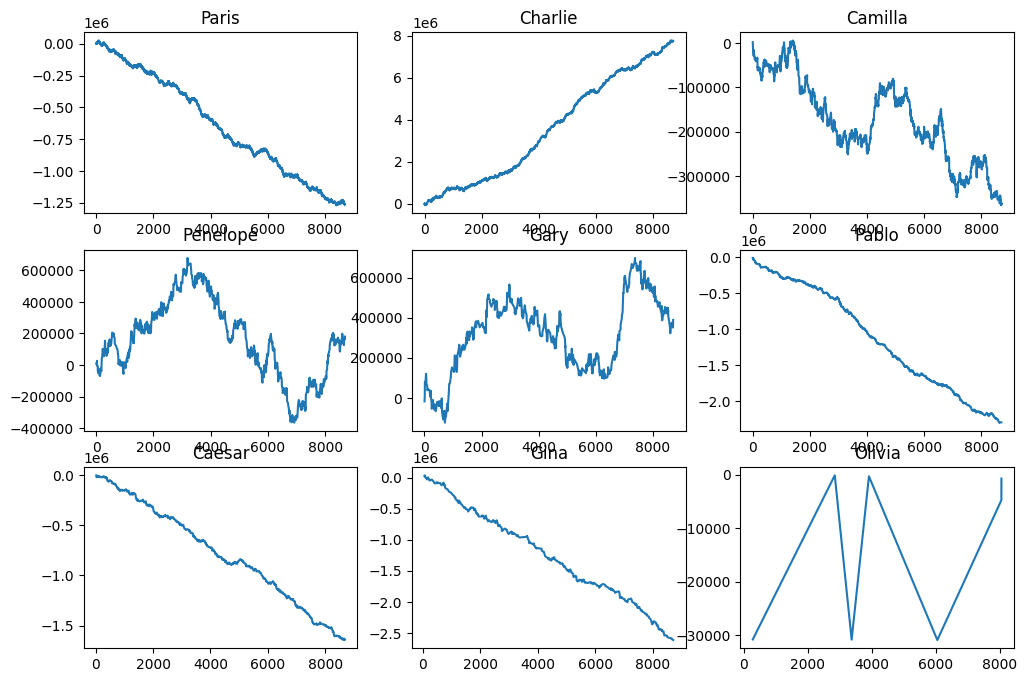

In [5]:
fig, axes = plt.subplots(3, 3, figsize=(12, 8))

for bot, ax in zip(bots, axes.flat):
    bot_trades = trades[(trades['buyer'] == bot) | (trades['seller'] == bot)]
    pnl = bot_trades.apply(lambda x: x['price'] * x['quantity'] if x['buyer'] == bot else -x['price'] * x['quantity'], axis=1)
    pnl = pnl.cumsum()
    ax.plot(pnl)
    ax.set_title(bot)
plt.show()